In [1]:
import glob
import numpy as np
import lightkurve as lk
import matplotlib.pyplot as plt
from astropy.io import fits
import pandas as pd
import pickle
import corner

from utils import estimate_frequencies, amplitude_spectrum

In [2]:
plt.style.use('science')

In [3]:
import astropy.units as u
import astropy.constants as const

def mass_function(period, asini):
    """Calculates the mass function for a given system
    
    Args:
        period (astropy.units.quantity.Quantity): Orbital period
        asini (astropy.units.quantity.Quantity): Convolved semi-major axis
    
    Returns:
        astropy.units.quantity.Quantity: Mass function in M_sun
    """
    si = (
        (4 * np.pi ** 2 * (1 * const.c ** 3))
        / (1 * const.G)
        * 1
        / (period.to(u.s) ** 2)
        * (asini ** 3)
    )
    return si#.to(u.M_sun)

def rv_semi_amplitude(period, mf, ecc=0):
    K1 = (
        (2 * np.pi * const.G)**(1/3)
        * np.sqrt(1-ecc**2)
        * (mf.to(u.kg) / period.to(u.s))**(1/3)
    )
    return K1.to(u.km/u.s)

mf = mass_function(22*u.day, 8*u.s)
rv_semi_amplitude(22*u.day, mf)

<Quantity 7.92782646 km / s>

In [4]:
(44.659*u.R_sun.to(u.m))/(const.c)

<Quantity 103.63591702 s / m>

In [27]:
mf = mass_function(51.41896*u.day,(( 44.659*u.R_sun).to(u.m)) / const.c)

In [29]:
rv_semi_amplitude(51.418946 * u.day, mf)

<Quantity 43.94139846 km / s>

In [34]:
np.sqrt(1-0.4211**2) * (2 * np.pi) * np.sin(np.radians(86.3653)) * (44.659 * u.R_sun).to(u.km) / (51.418946*u.day).to(u.s)

<Quantity 39.77531176 km / s>

\begin{align} \mathrm{ t_{0, \mathrm{ supconj }, \mathrm{   } } } &= 2458696.02599^{ +0.00016 }_{ -0.00016 } ~\mathrm{d} \\ \mathrm{ P_\mathrm{   } } &= 51.418946^{ +6.2e-05 }_{ -7e-05 } ~\mathrm{d} \\ \mathrm{ (R_\mathrm{ equiv, 1 } + R_\mathrm{ equiv, 2 }) / a_\mathrm{   } } &= 0.070092^{ +6.8e-05 }_{ -6.9e-05 } \mathrm{} \\ \mathrm{ R_\mathrm{ equiv, 2 } / R_\mathrm{ equiv, 1 } } &= 0.4634^{ +0.0025 }_{ -0.0026 } \mathrm{} \\ \mathrm{ i_\mathrm{   } } &= 86.3653^{ +0.0064 }_{ -0.0057 } \mathrm{{}^{\circ}} \\ \mathrm{ e_\mathrm{   } \sin \omega_0 } &= 0.15245^{ +0.00056 }_{ -0.00125 } \mathrm{} \\ \mathrm{ e_\mathrm{   } \cos \omega_0 } &= 0.395319^{ +7.3e-05 }_{ -5.1e-05 } \mathrm{} \\ \mathrm{ T_{ \mathrm{ eff }, \mathrm{ 1 } } } &= 11740.0^{ +270.0 }_{ -430.0 } ~\mathrm{K} \\ \mathrm{ T_\mathrm{ eff, 2 } / T_\mathrm{ eff, 1 } } &= 1.0045^{ +0.0066 }_{ -0.0083 } \mathrm{} \\ \mathrm{ q_\mathrm{   } } &= 0.37^{ +0.047 }_{ -0.046 } \mathrm{} \\ \mathrm{ a_\mathrm{ 1 } } &= 44.659^{ +0.06 }_{ -0.053 } ~\mathrm{R_{\odot}} \\ \mathrm{ v_\gamma } &= -11.755^{ +0.031 }_{ -0.028 } ~\mathrm{\frac{km}{s}} \\ \mathrm{ F_\mathrm{ 1 } } &= 4.4^{ +0.35 }_{ -0.45 } \mathrm{} \\ \mathrm{ F_\mathrm{ 2 } } &= 42.0^{ +16.0 }_{ -12.0 } \mathrm{} \\ \mathrm{ L_\mathrm{ pb, lc01 } } &= 10.35^{ +0.03 }_{ -0.027 } ~\mathrm{W} \\ \mathrm{ \sigma_\mathrm{ lnf, lc01 } } &= -8.38^{ +0.035 }_{ -0.034 } \mathrm{} \\ \mathrm{ \sigma_\mathrm{ lnf, rv01 } } &= -5.12^{ +0.16 }_{ -0.18 } \mathrm{} \\ \mathrm{ \beta_{ \mathrm{bol}, \mathrm{ 1 } } } &= 0.25^{ +0.15 }_{ -0.12 } \mathrm{} \\ \mathrm{ \beta_{ \mathrm{bol}, \mathrm{ 2 } } } &= 0.51^{ +0.28 }_{ -0.21 } \mathrm{} \\ \mathrm{ A_{ \mathrm{bol}, \mathrm{ 1 } } } &= 0.59^{ +0.12 }_{ -0.17 } \mathrm{} \\ \mathrm{ A_{ \mathrm{bol}, \mathrm{ 2 } } } &= 0.58^{ +0.14 }_{ -0.2 } \mathrm{} \\  \end{align}

In [4]:
af_stars = pd.read_csv('../data/catalogues/rev_AF_stars.csv', dtype={'kic': str})
koi_dsct = pd.read_csv('data/koi_dsct.csv')
# cand = pd.DataFrame({
#     'kepid': ['4380834', '5724523', '7767699', '8249829', '9895543'],
#     'period': [0.889896, 0.545784, 1.128263, 1.012737, 1.218900],
#     'e_period': [0.000023, 0.000010, 0.000037, 0.000101, 0.000025],
#     'nfreqs': [
#     2,
#     3,
#     3,
#     1,
#     2
# ]
# })

cand = pd.DataFrame({
    'kepid': ['7767699', '8249829', '9895543'],
    'period': [1.128263, 1.012737, 1.218900],
    'e_period': [0.000037, 0.000101, 0.000025],
    'nfreqs': [
    3,
    1,
    2
]
})
cand = af_stars.merge(cand, left_on='kic', right_on='kepid')

# Candidates


In [7]:
# ii = 0

# kepid = cand.iloc[ii].kepid

# with open(f'traces/{cand.iloc[ii].kepid}.pkl', 'rb') as buff:
#     data = pickle.load(buff)  

# model, trace = data['model'], data['trace']

In [5]:
cand_masses, cand_masses_low, cand_masses_hi = [], [], []
cand_keps = []
cand_periods = []
for index, row in cand.iterrows():
        with open(f'traces/{row.kepid}.pkl', 'rb') as buff:
            data = pickle.load(buff)  

        model, trace = data['model'], data['trace']

        mf = mass_function(trace["period"] * u.day, trace["asini"] * u.s)
        mass = (mf.to(u.M_jup))**(1/3) * ((row.new_mass*u.M_sun).to(u.M_jup))**(2/3)

        cand_periods.append(np.median(trace["period"]))
        cand_masses.append(np.median(mass.value))
        percs = np.percentile(mass, [15.83, 50, 84.16]).value
        cand_masses_low.append(percs[1]-percs[0])
        cand_masses_hi.append(percs[2] - percs[1])

In [6]:
cand_masses

[2105.2854690412078, 221.1279212526204, 317.4751732189732]

# KOI

In [25]:
ii = -3

In [26]:
kepid = koi_dsct.iloc[ii].kepid

with open(f'traces/{koi_dsct.iloc[ii].kepoi_name}.pkl', 'rb') as buff:
    data = pickle.load(buff)  

model, trace = data['model'], data['trace']

In [27]:
mf = mass_function(trace["period"] * u.day, trace["asini"] * u.s)
mass = (mf.to(u.M_jup))**(1/3) * ((koi_dsct.iloc[ii].koi_smass*u.M_sun).to(u.M_jup))**(2/3)

In [28]:
mf

<Quantity [1.66369040e+25, 6.16939036e+26, 4.42059304e+24, ...,
           4.25292902e+25, 4.51566811e+25, 2.82798937e+23] kg>

(array([573., 471., 377., 294., 150.,  84.,  32.,  14.,   3.,   2.]),
 array([2.87022511e-02, 2.19212663e+01, 4.38138304e+01, 6.57063945e+01,
        8.75989586e+01, 1.09491523e+02, 1.31384087e+02, 1.53276651e+02,
        1.75169215e+02, 1.97061779e+02, 2.18954343e+02]),
 <BarContainer object of 10 artists>)

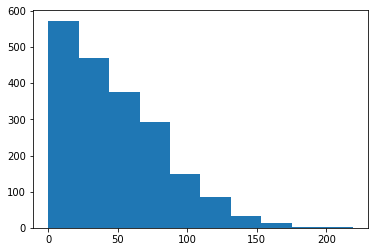

In [29]:
plt.hist(mass.value)

<Figure size 360x360 with 0 Axes>

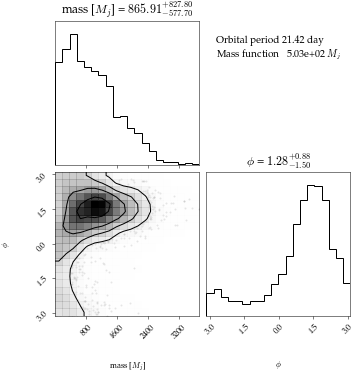

In [86]:
plt.figure(figsize=[5,5])
asini_min_idx = np.argmin(np.median(trace['asini'], axis=0))
fig = corner.corner(np.array([mass, trace['phi']]).T,
             show_titles=True,
             labels=[r'mass [$M_j$]', '$\phi$'],
             smooth=1);

ax = fig.add_subplot(2,2,2)
ax.axis('off')

ax.text(0.07, 0.85, f'Orbital period {koi_dsct.iloc[ii].koi_period:.2f} day')
ax.text(0.07, 0.75, f'Mass function \t{np.median(mf.to(u.M_jup).value):.2e} $M_j$')
# ax.text(0.07, 0.65, f'Stellar mass \t{koi_dsct.iloc[ii].koi_smass:.2f} {mf.unit.to_string("latex")}')
# # ax.text(0.07, 0.55, f'Planet mass \t{mass.value:.2f}{mass.unit.to_string("latex")}')

plt.savefig('hmm.png', dpi=300, bbox_inches='tight', transparent=False)

In [7]:
masses, masses_low, masses_hi = [], [], []
keps = []
periods = []
for index, row in koi_dsct.iterrows():
        with open(f'traces/{row.kepoi_name}.pkl', 'rb') as buff:
            data = pickle.load(buff)  

        model, trace = data['model'], data['trace']

        mf = mass_function(trace["period"] * u.day, trace["asini"] * u.s)
        mass = (mf.to(u.M_jup))**(1/3) * ((row.koi_smass*u.M_sun).to(u.M_jup))**(2/3)
        
        periods.append(np.median(trace["period"]))
        masses.append(np.median(mass.value))
        percs = np.percentile(mass, [15.83, 50, 84.16]).value
        masses_low.append(percs[1]-percs[0])
        masses_hi.append(percs[2] - percs[1])

In [25]:
koi_dsct

,Unnamed: 0,Unnamed: 0.1,kepid,kepoi_name,kepler_name,koi_disposition,koi_vet_stat,koi_vet_date,koi_pdisposition,koi_score,...,koi_dicco_msky,koi_dicco_msky_err,koi_dikco_mra,koi_dikco_mra_err,koi_dikco_mdec,koi_dikco_mdec_err,koi_dikco_msky,koi_dikco_msky_err,dsct,nfreqs
0,0,0,3964109,K00393.01,Kepler-544 b,CONFIRMED,Done,16/8/18,CANDIDATE,1.000,...,0.63,0.57,0.000,1.300,0.500,0.510,0.500,0.530,True,1
1,1,1,9111849,K02042.01,NaN,CANDIDATE,Done,16/8/18,CANDIDATE,0.994,...,0.31,0.13,0.150,0.120,-0.200,0.130,0.250,0.130,True,4
2,2,2,9845898,K02423.01,Kepler-1233 b,CONFIRMED,Done,16/8/18,CANDIDATE,1.000,...,0.60,0.85,0.110,0.700,-0.700,1.100,0.700,1.100,True,3
3,3,3,5202905,K01932.01,Kepler-340 c,CONFIRMED,Done,16/8/18,CANDIDATE,0.944,...,0.32,0.23,-0.110,0.260,0.430,0.230,0.440,0.220,True,4
4,4,4,5202905,K01932.02,Kepler-340 b,CONFIRMED,Done,16/8/18,CANDIDATE,0.636,...,0.39,0.39,0.400,0.440,-0.150,0.250,0.430,0.400,True,4
5,5,5,6116172,K06142.02,NaN,CANDIDATE,Done,16/8/18,CANDIDATE,NaN,...,7.90,2.70,-8.000,2.100,-0.580,0.230,8.000,2.100,True,1
6,6,6,6116172,K06142.01,NaN,CANDIDATE,Done,16/8/18,CANDIDATE,NaN,...,7.90,2.70,-8.000,2.100,-0.580,0.230,8.000,2.100,True,1
7,7,7,6116172,K06142.02,NaN,CANDIDATE,Done,16/8/18,CANDIDATE,NaN,...,7.90,2.70,-8.000,2.100,-0.580,0.230,8.000,2.100,True,1
8,8,8,11013201,K00972.03,NaN,CANDIDATE,Done,16/8/18,CANDIDATE,0.632,...,5.20,1.50,-3.210,0.810,4.300,1.100,5.400,1.300,True,4
9,9,9,11013201,K00972.02,NaN,CANDIDATE,Done,16/8/18,CANDIDATE,0.000,...,3.90,1.70,-4.700,1.200,3.000,1.800,5.600,1.700,True,4


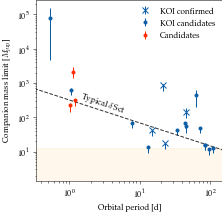

In [8]:
plt.figure(figsize=[3.333, 3.333])

m = koi_dsct['koi_disposition'] == 'CONFIRMED'
plt.errorbar(np.array(periods)[m], np.array(masses)[m], yerr=[np.array(masses)[m]-np.array(masses_low)[m], np.abs(np.array(masses)[m]-np.array(masses_hi)[m])], fmt='x', c='C0', label='KOI confirmed')
plt.errorbar(np.array(periods)[~m], np.array(masses)[~m], yerr=[np.array(masses)[~m]-np.array(masses_low)[~m], np.abs(np.array(masses)[~m]-np.array(masses_hi)[~m])], fmt='.',  c='C0', label='KOI candidates')
plt.errorbar(cand_periods, cand_masses, yerr=[np.array(cand_masses)-np.array(cand_masses_low), np.abs(np.array(cand_masses)-np.array(cand_masses_hi))], fmt='.', c='C3', label='Candidates')

plt.fill_between([0,5000], 0, 13, alpha=0.08, color='orange')
plt.text
# plt.axhline(13, linestyle='dashed', c='black', linewidth=0.7)
plt.yscale('log')
plt.xscale('log')
plt.xlabel('Orbital period [d]')
plt.ylabel(r'Companion mass limit [$M_{\rm jup}$]')
plt.xlim(None,150)
# plt.ylim(None, 2000)

# gradient_fill(np.array([0,200]),np.array([13,13]), fill_color='red')
periodss = np.geomspace(0.01,1470,500)
stellar_mass = 1.8

worst_case = (mass_function(periodss*u.day, 8*u.s).to(u.M_jup))**(1/3) * ((stellar_mass*u.M_sun).to(u.M_jup))**(2/3)
typical_case = (mass_function(periodss*u.day, 2*u.s).to(u.M_jup))**(1/3) * ((stellar_mass*u.M_sun).to(u.M_jup))**(2/3)
best_case = (mass_function(periodss*u.day, 1*u.s).to(u.M_jup))**(1/3) * ((stellar_mass*u.M_sun).to(u.M_jup))**(2/3)

plt.plot(periodss, typical_case, c='black', linewidth=1, alpha=0.8, linestyle='dashed')
plt.text(3, 16**2, f'Typical $\delta$ Sct', rotation=-19, fontsize=8,horizontalalignment='center',      verticalalignment='center')
# plt.plot(periodss, worst_case,  c='red', linewidth=1, alpha=0.25)
# plt.plot(periodss, best_case, c='green', linewidth=1, alpha=0.25)
# X = [[.6, .6], [.7, .7]]
plt.legend(fontsize=8)
# plt.imshow(X, interpolation='bicubic', cmap='copper', alpha=1)
plt.savefig('pulsation_timing.pdf', dpi=300, transparent=False, bbox_inches='tight', pad_inches=0.)

# Printing the results

In [47]:
# for index, row in cand[:].iterrows():
#         with open(f'traces/{row.kepid}.pkl', 'rb') as buff:
#             data = pickle.load(buff)  

#         model, trace = data['model'], data['trace']

#         mf = mass_function(trace["period"] * u.day, trace["asini"] * u.s)
#         mass = (mf.to(u.M_jup))**(1/3) * ((row.new_mass*u.M_sun).to(u.M_jup))**(2/3)
#         K1 = rv_semi_amplitude(trace['period']*u.day, mf)
        
#         percs = np.percentile(trace['asini'], [15.83, 50, 84.16])
#         lower, upper = pm.stats.hdi(trace['asini'], hdi_prob=.68)
#         print(row.kepid, f' & ${percs[1]:.1f}^{{+{upper:.1f}}}_{{-{lower:.1f}}}$', end=' & ')
        
#         percs = np.percentile(mass, [15.83, 50, 84.16]).value
#         lower, upper = pm.stats.hdi(mass.value, hdi_prob=.68)
#         print(f' & ${percs[1]:.1f}^{{+{upper:.1f}}}_{{-{lower:.1f}}}$', end=' & ')
        
#         percs = np.percentile(K1, [15.83, 50, 84.16]).value
#         lower, upper = pm.stats.hdi(K1.value, hdi_prob=.68)
#         print(f' & ${percs[1]:.1f}^{{+{upper:.1f}}}_{{-{lower:.1f}}}$', end=' \\\\ \n')
# #         print(f'${percs[1]:.1f}^{{+{percs[1] - percs[0]:.1f}}}_{{-{percs[2] - percs[1]:.1f}}}$', end=' \\\\ \n')

4380834  & $5.1^{+7.5}_{-0.1}$ &  & $758.7^{+1103.2}_{-7.5}$ &  & $125.7^{+182.8}_{-1.3}$ \\ 
5724523  & $46.2^{+67.7}_{-0.0}$ &  & $11421.7^{+16731.7}_{-3.0}$ &  & $1845.2^{+2703.0}_{-0.5}$ \\ 
7767699  & $14.6^{+21.6}_{-3.7}$ &  & $2105.3^{+3105.8}_{-526.6}$ &  & $283.0^{+417.5}_{-70.8}$ \\ 
8249829  & $1.5^{+2.3}_{-0.0}$ &  & $221.1^{+335.6}_{-0.7}$ &  & $33.0^{+50.1}_{-0.1}$ \\ 
9895543  & $2.4^{+3.6}_{-0.1}$ &  & $317.5^{+478.8}_{-18.6}$ &  & $42.7^{+64.5}_{-2.5}$ \\ 


In [24]:
plt.style.use('default')

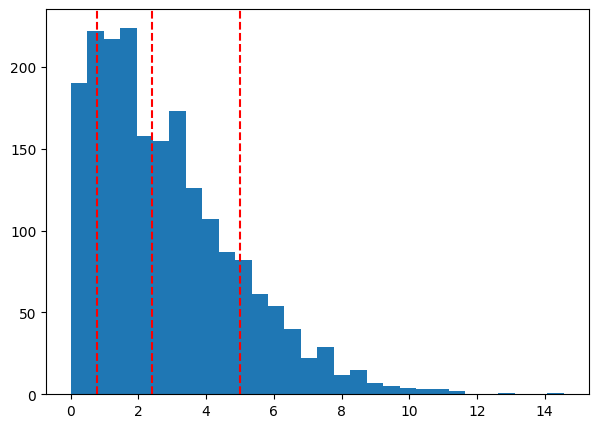

In [26]:
plt.figure(figsize=[7,5])
plt.hist(trace['asini'], bins=30)
percs = np.percentile(trace['asini'], [15.83, 50, 84.16])
for p in percs:
    plt.axvline(p, c='r', linestyle='dashed')

In [37]:
print(f'${percs[1]:.2f}^{{+{percs[1] - percs[0]:.2f}}}_{{-{percs[2] - percs[1]:.2f}}}$', end=' \\\\ \n')

$2.39^{+1.62}_{-2.60}$ \\ 


In [50]:
x = trace['asini']
lower, upper = pm.stats.hdi(x, hdi_prob=.68)
med = np.median(x)

In [56]:
lower, upper

(0.13988179217016758, 3.603673161328536)

In [51]:
med

2.3897179021379547

In [54]:
upper - med # +

1.2139552591905813

In [55]:
med - lower # -

2.249836109967787

In [10]:
np.percentile(trace['asini'], 95)

14.075039709186973

In [20]:
for index, row in cand[:].iterrows():
        with open(f'traces/{row.kepid}.pkl', 'rb') as buff:
            data = pickle.load(buff)  

        model, trace = data['model'], data['trace']

        mf = mass_function(trace["period"] * u.day, trace["asini"] * u.s)
        mass = (mf.to(u.M_jup))**(1/3) * ((row.new_mass*u.M_sun).to(u.M_jup))**(2/3)
        K1 = rv_semi_amplitude(trace['period']*u.day, mf)
        
        print(row.kepid, f' & ${np.percentile(trace["asini"], 95):.1f}$', end=' & ')
        print(f' ${np.percentile(mass.value, 95):.1f}$', end=' & ')
        print(f' ${np.percentile(K1.value, 95):.1f}$', end=' \\\\ \n')
        
#         lower, upper = pm.stats.hdi(mass.value, hdi_prob=.68)
#         med = np.median(mass.value)
#         print(f' & ${med:.1f}^{{+{upper - med:.1f}}}_{{-{med - lower:.1f}}}$', end=' & ')
        
#         lower, upper = pm.stats.hdi(K1.value, hdi_prob=.68)
#         med = np.median(K1.value)
#         print(f' & ${med:.1f}^{{+{upper - med:.1f}}}_{{-{med - lower:.1f}}}$', end=' \\\\ \n')
#         print(f'${percs[1]:.1f}^{{+{percs[1] - percs[0]:.1f}}}_{{-{percs[2] - percs[1]:.1f}}}$', end=' \\\\ \n')

print("KOI")
for index, row in koi_dsct[:].iterrows():
        with open(f'traces/{row.kepoi_name}.pkl', 'rb') as buff:
            data = pickle.load(buff)  

        model, trace = data['model'], data['trace']

        mf = mass_function(trace["period"] * u.day, trace["asini"] * u.s)
        mass = (mf.to(u.M_jup))**(1/3) * ((row.koi_smass*u.M_sun).to(u.M_jup))**(2/3)
        K1 = rv_semi_amplitude(trace['period']*u.day, mf)
        print(row.kepid, f' & ${np.percentile(trace["asini"], 95):.1f}$', end=' & ')
        print(f' ${np.percentile(mass.value, 95):.1f}$', end=' & ')
        print(f' ${np.percentile(K1.value, 95):.1f}$', end=' \\\\ \n')

4380834  & $14.1$ &  $2081.0$ &  $344.8$ \\ 
5724523  & $127.3$ &  $31477.3$ &  $5085.3$ \\ 
7767699  & $29.8$ &  $4277.4$ &  $575.0$ \\ 
8249829  & $4.7$ &  $673.6$ &  $100.5$ \\ 
9895543  & $6.9$ &  $918.8$ &  $123.7$ \\ 
KOI
3964109  & $151.5$ &  $2225.7$ &  $154.3$ \\ 
9111849  & $65.2$ &  $787.4$ &  $22.5$ \\ 
9845898  & $32.8$ &  $311.9$ &  $15.8$ \\ 
5202905  & $2.8$ &  $47.6$ &  $2.7$ \\ 
5202905  & $4.7$ &  $105.6$ &  $6.9$ \\ 
6116172  & $6.0$ &  $44.3$ &  $1.5$ \\ 
6116172  & $5.7$ &  $35.0$ &  $1.1$ \\ 
6116172  & $6.0$ &  $44.3$ &  $1.5$ \\ 
11013201  & $1.2$ &  $36.8$ &  $2.0$ \\ 
11013201  & $4.4$ &  $192.5$ &  $12.3$ \\ 
6032730  & $4.4$ &  $33.0$ &  $1.0$ \\ 
5617259  & $12.0$ &  $1850.4$ &  $250.3$ \\ 
9775385  & $10.4$ &  $124.2$ &  $5.0$ \\ 
6670742  & $14.2$ &  $142.3$ &  $4.3$ \\ 
9289704  & $6.0$ &  $116.5$ &  $3.9$ \\ 
3965201  & $14.0$ &  $193.1$ &  $6.9$ \\ 
11180361  & $321.1$ &  $87717.5$ &  $13134.1$ \\ 


In [5]:
# for index, row in cand[:].iterrows():
#         with open(f'traces/{row.kepid}.pkl', 'rb') as buff:
#             data = pickle.load(buff)  

#         model, trace = data['model'], data['trace']

#         mf = mass_function(trace["period"] * u.day, trace["asini"] * u.s)
#         mass = (mf.to(u.M_jup))**(1/3) * ((row.new_mass*u.M_sun).to(u.M_jup))**(2/3)
#         K1 = rv_semi_amplitude(trace['period']*u.day, mf)
        
#         lower, upper = pm.stats.hdi(trace['asini'], hdi_prob=.68)
#         med = np.median(trace['asini'])
#         print(row.kepid, f' & ${med:.1f}^{{+{upper - med:.1f}}}_{{-{med - lower:.1f}}}$', end=' & ')
        
#         lower, upper = pm.stats.hdi(mass.value, hdi_prob=.68)
#         med = np.median(mass.value)
#         print(f' & ${med:.1f}^{{+{upper - med:.1f}}}_{{-{med - lower:.1f}}}$', end=' & ')
        
#         lower, upper = pm.stats.hdi(K1.value, hdi_prob=.68)
#         med = np.median(K1.value)
#         print(f' & ${med:.1f}^{{+{upper - med:.1f}}}_{{-{med - lower:.1f}}}$', end=' \\\\ \n')
# #         print(f'${percs[1]:.1f}^{{+{percs[1] - percs[0]:.1f}}}_{{-{percs[2] - percs[1]:.1f}}}$', end=' \\\\ \n')

NameError: name 'pm' is not defined

In [107]:
for index, row in koi_dsct[:].iterrows():
        with open(f'traces/{row.kepoi_name}.pkl', 'rb') as buff:
            data = pickle.load(buff)  

        model, trace = data['model'], data['trace']

        mf = mass_function(trace["period"] * u.day, trace["asini"] * u.s)
        mass = (mf.to(u.M_jup))**(1/3) * ((row.koi_smass*u.M_sun).to(u.M_jup))**(2/3)
        K1 = rv_semi_amplitude(trace['period']*u.day, mf)
        
        percs = np.percentile(trace['asini'], [15.83, 50, 84.16])
        print(row.kepid, f' & ${percs[1]:.1f}^{{+{percs[1] - percs[0]:.1f}}}_{{-{percs[2] - percs[1]:.1f}}}$', end=' & ')
        
        percs = np.percentile(mass, [15.83, 50, 84.16]).value
        print(f'${percs[1]:.1f}^{{+{percs[1] - percs[0]:.1f}}}_{{-{percs[2] - percs[1]:.1f}}}$', end=' & ')
        
        percs = np.percentile(K1, [15.83, 50, 84.16]).value
        print(f'${percs[1]:.1f}^{{+{percs[1] - percs[0]:.1f}}}_{{-{percs[2] - percs[1]:.1f}}}$', end=' \\\\ \n')

3964109  & $59.0^{+39.6}_{-56.6}$ & $865.9^{+581.3}_{-830.6}$ & $60.0^{+40.3}_{-57.6}$ \\ 
9111849  & $35.8^{+17.0}_{-18.5}$ & $432.5^{+204.9}_{-223.4}$ & $12.4^{+5.9}_{-6.4}$ \\ 
9845898  & $15.0^{+9.8}_{-10.9}$ & $142.9^{+93.3}_{-103.4}$ & $7.3^{+4.7}_{-5.3}$ \\ 
5202905  & $1.0^{+0.7}_{-1.1}$ & $17.2^{+12.2}_{-18.0}$ & $1.0^{+0.7}_{-1.0}$ \\ 
5202905  & $1.8^{+1.3}_{-1.8}$ & $41.0^{+28.4}_{-39.9}$ & $2.7^{+1.9}_{-2.6}$ \\ 
6116172  & $2.1^{+1.5}_{-2.2}$ & $15.1^{+10.9}_{-16.5}$ & $0.5^{+0.4}_{-0.6}$ \\ 
6116172  & $2.0^{+1.5}_{-2.2}$ & $12.4^{+9.0}_{-13.4}$ & $0.4^{+0.3}_{-0.4}$ \\ 
6116172  & $2.1^{+1.5}_{-2.2}$ & $15.1^{+10.9}_{-16.5}$ & $0.5^{+0.4}_{-0.6}$ \\ 
11013201  & $0.4^{+0.3}_{-0.4}$ & $13.5^{+9.3}_{-13.6}$ & $0.7^{+0.5}_{-0.7}$ \\ 
11013201  & $1.6^{+1.2}_{-1.7}$ & $68.0^{+50.0}_{-75.8}$ & $4.4^{+3.2}_{-4.9}$ \\ 
6032730  & $1.5^{+1.0}_{-1.6}$ & $11.6^{+7.9}_{-11.8}$ & $0.3^{+0.2}_{-0.4}$ \\ 
5617259  & $4.0^{+2.8}_{-4.7}$ & $610.9^{+436.2}_{-721.0}$ & $82.6^{+59.0}_{-97

In [97]:
percs[1] - percs[0]

<Quantity 581.32939554 jupiterMass>

In [17]:
df = koi_dsct.merge(res, left_on='kepid', right_on='id')

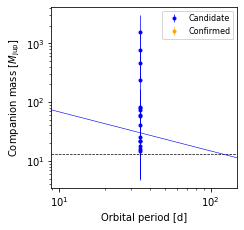

In [21]:
plt.figure(figsize=[10/3, 10/3])

mask = df['koi_disposition'] == 'CANDIDATE'
plt.errorbar(df[mask]['koi_period'], df[mask]['pm_mass'],yerr=[df[mask]['pm_mass_low'].values, df[mask]['pm_mass_hi'].values], fmt='.', elinewidth=0.7, color='blue', label='Candidate')
plt.errorbar(df[~mask]['koi_period'], df[~mask]['pm_mass'],yerr=[df[~mask]['pm_mass_low'].values, 
                                                                 df[~mask]['pm_mass_hi'].values], fmt='.', elinewidth=0.7, color='orange', label='Confirmed')

# plt.fill_between([0,120], 5000, 13, alpha=0.05, color='orange')
plt.axhline(13, linestyle='dashed', c='black', linewidth=0.7)
plt.yscale('log')
plt.xscale('log')
plt.xlabel('Orbital period [d]')
plt.ylabel(r'Companion mass [$M_{\rm jup}$]')
plt.xlim(None,150)
plt.ylim(None, None)

plt.legend(fontsize=8)

# gradient_fill(np.array([0,200]),np.array([13,13]), fill_color='red')
periods = np.geomspace(0.01,1470,500)
stellar_mass = 1.8

# # worst_case = (mass_function(periods*u.day, 8*u.s).to(u.M_jup))**(1/3) * ((stellar_mass*u.M_sun).to(u.M_jup))**(2/3)
typical_case = (mass_function(periods*u.day, 2*u.s).to(u.M_jup))**(1/3) * ((stellar_mass*u.M_sun).to(u.M_jup))**(2/3)
# # best_case = (mass_function(periods*u.day, 1*u.s).to(u.M_jup))**(1/3) * ((stellar_mass*u.M_sun).to(u.M_jup))**(2/3)

plt.plot(periods, typical_case, label='SNR=500', c='blue', linewidth=0.6)

# plt.savefig(overleaf_path + 'results_koi.pdf', dpi=300, bbox_inches='tight', pad_inches=0.)

In [28]:
print('a')

a


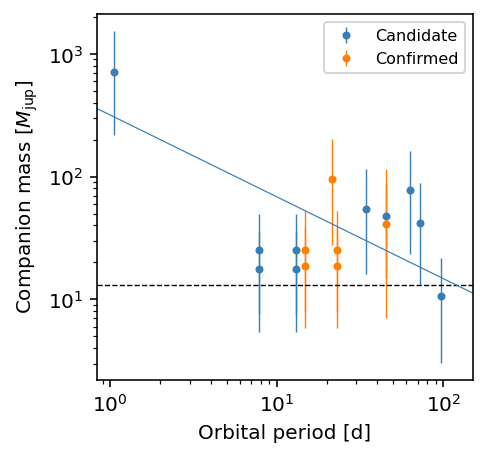

In [17]:
plt.figure(figsize=mnras_size(242.26653, square=True))

mask = df['koi_disposition'] == 'CANDIDATE'
plt.errorbar(df[mask]['koi_period'], df[mask]['pm_mass'],yerr=[df[mask]['pm_mass_low'].values, df[mask]['pm_mass_hi'].values], fmt='.', elinewidth=0.7, color=blue, label='Candidate')
plt.errorbar(df[~mask]['koi_period'], df[~mask]['pm_mass'],yerr=[df[~mask]['pm_mass_low'].values, df[~mask]['pm_mass_hi'].values], fmt='.', elinewidth=0.7, color=orange, label='Confirmed')

# plt.fill_between([0,120], 5000, 13, alpha=0.05, color='orange')
plt.axhline(13, linestyle='dashed', c='black', linewidth=0.7)
plt.yscale('log')
plt.xscale('log')
plt.xlabel('Orbital period [d]')
plt.ylabel(r'Companion mass [$M_{\rm jup}$]')
plt.xlim(None,150)
plt.ylim(None, None)

plt.legend(fontsize=8)

# gradient_fill(np.array([0,200]),np.array([13,13]), fill_color='red')
periods = np.geomspace(0.01,1470,500)
stellar_mass = 1.8

# # worst_case = (mass_function(periods*u.day, 8*u.s).to(u.M_jup))**(1/3) * ((stellar_mass*u.M_sun).to(u.M_jup))**(2/3)
typical_case = (mass_function(periods*u.day, 2*u.s).to(u.M_jup))**(1/3) * ((stellar_mass*u.M_sun).to(u.M_jup))**(2/3)
# # best_case = (mass_function(periods*u.day, 1*u.s).to(u.M_jup))**(1/3) * ((stellar_mass*u.M_sun).to(u.M_jup))**(2/3)

plt.plot(periods, typical_case, label='SNR=500', c=blue, linewidth=0.6)

# plt.savefig(overleaf_path + 'results_koi.pdf', dpi=300, bbox_inches='tight', pad_inches=0.)

In [18]:
df[df['koi_disposition'] == 'CONFIRMED'][['kepid', 'pm_mass']]

,kepid,pm_mass
0,3964109,96.194093
1,5202905,18.842860
2,5202905,25.101777
3,5202905,18.842860
4,5202905,25.101777
11,9845898,40.767023


In [22]:
ii = 11
kepid = koi_dsct.iloc[ii].kepid

In [23]:
def low_pass(t, y, width=3.):
    return gaussian_filter(y, width)

In [24]:
t, y = get_kepler_lc(kepid)
y = low_pass(t, y, 5)

In [25]:
# ms = Maelstrom(t, y, max_peaks=3, fmin=5, fmax=41)
# ax = ms.first_look();
# koi_period = koi_dsct.iloc[ii].koi_period
# ax[3].axvline(1./koi_period, c='g', linestyle='dashed')

In [26]:
from astropy.stats import BoxLeastSquares

m = np.zeros(len(t), dtype=bool)
period_grid = np.exp(np.linspace(np.log(5), np.log(150), 50000))
bls_results = []
periods = []
t0s = []
depths = []
durations = []
stats = []
# Compute the periodogram for each star by iteratively masking out
# eclipses from the higher signal to noise star.
for i in range(1):
    bls = BoxLeastSquares(t[~m], y[~m])
    bls_power = bls.power(period_grid, 0.1, oversample=20)
    bls_results.append(bls_power)

    # Save the highest peak as the planet candidate
    index = np.argmax(bls_power.power)
    periods.append(bls_power.period[index])
    t0s.append(bls_power.transit_time[index])
    depths.append(bls_power.depth[index])
    durations.append(bls_power.duration[index])
    
    stats.append(bls.compute_stats(periods[i], durations[i], t0s[i]))

    # Mask the data points that are in transit for this candidate
    m |= bls.transit_mask(t, periods[-1], 0.5, t0s[-1])

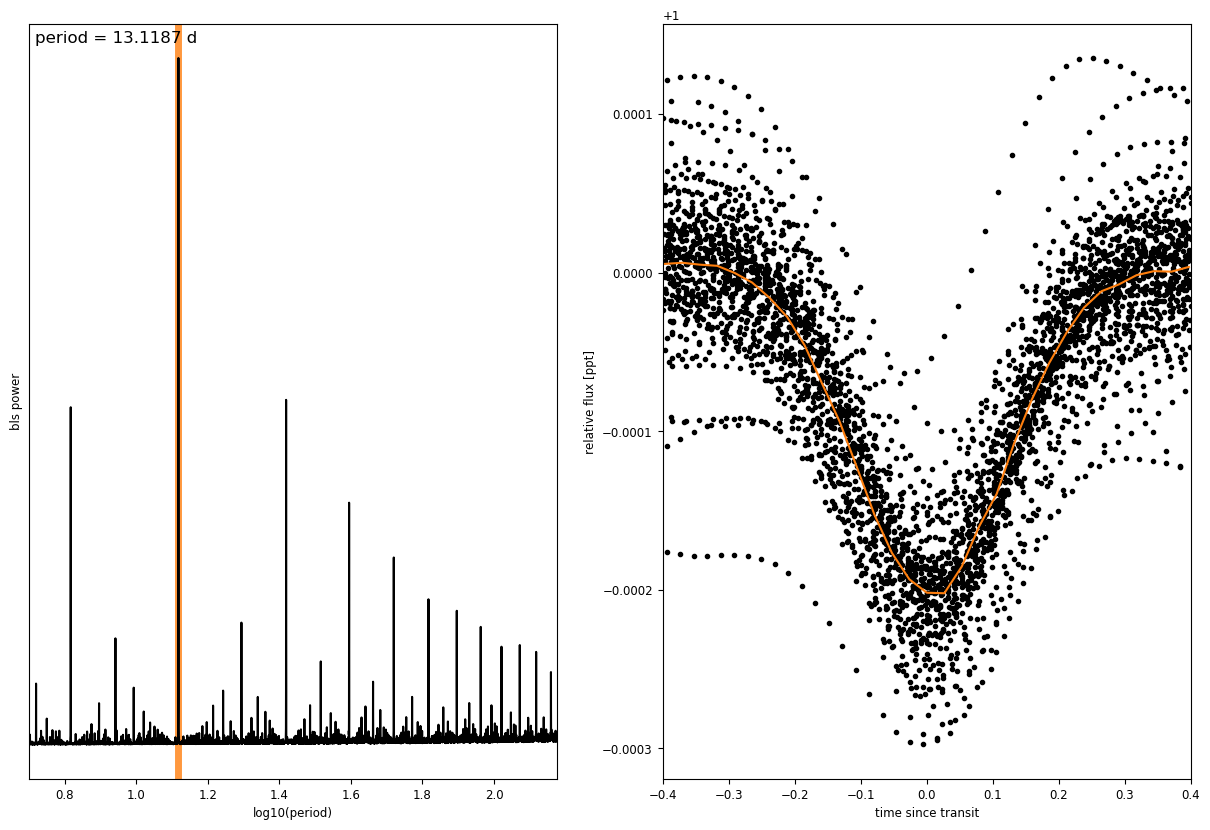

In [27]:
fig, axes = plt.subplots(len(bls_results), 2, figsize=(15, 10))

for i in range(len(bls_results)):
    # Plot the periodogram
    ax = axes[i]
    ax.axvline(np.log10(periods[i]), color="C1", lw=5, alpha=0.8)
    ax.plot(np.log10(bls_results[i].period), bls_results[i].power, "k")
    ax.annotate("period = {0:.4f} d".format(periods[i]),
                (0, 1), xycoords="axes fraction",
                xytext=(5, -5), textcoords="offset points",
                va="top", ha="left", fontsize=12)
    ax.set_ylabel("bls power")
    ax.set_yticks([])
    ax.set_xlim(np.log10(period_grid.min()), np.log10(period_grid.max()))
    if i < len(bls_results) - 1:
        ax.set_xticklabels([])
    else:
        ax.set_xlabel("log10(period)")

    # Plot the folded transit
    ax = axes[1]
    p = periods[i]
    x_fold = (t - t0s[i] + 0.5*p) % p - 0.5*p
    m = np.abs(x_fold) < 0.4
    ax.plot(x_fold[m], y[m], ".k")

    # Overplot the phase binned light curve
    bins = np.linspace(-0.41, 0.41, 32)
    denom, _ = np.histogram(x_fold, bins)
    num, _ = np.histogram(x_fold, bins, weights=y)
    denom[num == 0] = 1.0
    ax.plot(0.5*(bins[1:] + bins[:-1]), num / denom, color="C1")

    ax.set_xlim(-0.4, 0.4)
    ax.set_ylabel("relative flux [ppt]")
    if i < len(bls_results) - 1:
        ax.set_xticklabels([])
    else:
        ax.set_xlabel("time since transit")

fig.subplots_adjust(hspace=0.02)

In [31]:
koi_dsct.iloc[ii].koi_period

45.126216

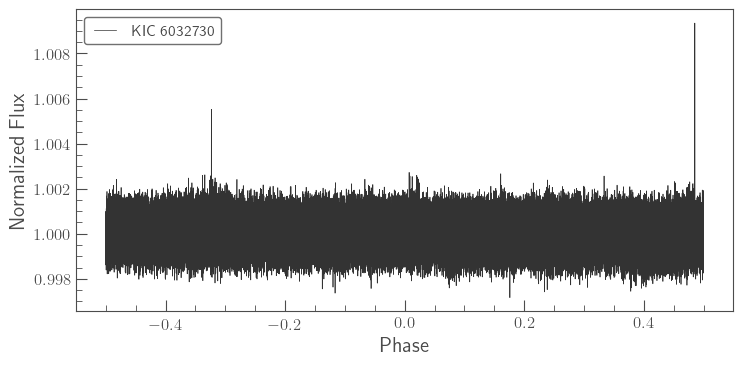

In [28]:
lc.fold(period=koi_dsct.iloc[ii].koi_period).plot()

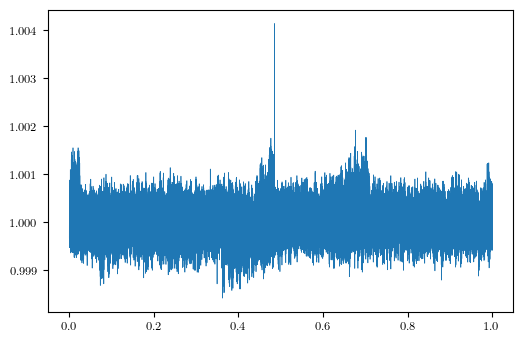

In [26]:
t, y = get_kepler_lc(kepid)
lp = low_pass(t, y, width=1)

fold = t % koi_dsct.iloc[ii].koi_period / koi_dsct.iloc[ii].koi_period
sort = np.argsort(fold)
plt.plot(fold[sort], lp[sort], linewidth=0.5)

In [160]:
koi_dsct.iloc[ii].koi_period

96.509214

In [148]:
koi.koi_time0

0       2454977.660
1       2455026.304
2       2454979.349
3       2454964.693
4       2454965.469
           ...     
1166    2454967.423
1167    2454972.346
1168    2455029.391
1169    2454953.566
1170    2454977.215
Name: koi_time0, Length: 1171, dtype: float64

In [146]:
for col in koi.columns:
    print(col)

Unnamed: 0
rowid
kepid
kepoi_name
kepler_name
koi_disposition
koi_vet_stat
koi_vet_date
koi_pdisposition
koi_score
koi_fpflag_nt
koi_fpflag_ss
koi_fpflag_co
koi_fpflag_ec
koi_disp_prov
koi_comment
koi_period
koi_period_err1
koi_period_err2
koi_time0bk
koi_time0bk_err1
koi_time0bk_err2
koi_time0
koi_time0_err1
koi_time0_err2
koi_eccen
koi_eccen_err1
koi_eccen_err2
koi_longp
koi_longp_err1
koi_longp_err2
koi_impact
koi_impact_err1
koi_impact_err2
koi_duration
koi_duration_err1
koi_duration_err2
koi_ingress
koi_ingress_err1
koi_ingress_err2
koi_depth
koi_depth_err1
koi_depth_err2
koi_ror
koi_ror_err1
koi_ror_err2
koi_srho
koi_srho_err1
koi_srho_err2
koi_fittype
koi_prad
koi_prad_err1
koi_prad_err2
koi_sma
koi_sma_err1
koi_sma_err2
koi_incl
koi_incl_err1
koi_incl_err2
koi_teq
koi_teq_err1
koi_teq_err2
koi_insol
koi_insol_err1
koi_insol_err2
koi_dor
koi_dor_err1
koi_dor_err2
koi_limbdark_mod
koi_ldm_coeff4
koi_ldm_coeff3
koi_ldm_coeff2
koi_ldm_coeff1
koi_parm_prov
koi_max_sngle_ev
koi_max_m

216.26718315800912 jupiterMass
